# Vision Transformer from Scratch

## Overview of ViT:

ViT's architecture was inspired by BERT, an encoder-only transformer model that is often used in NLP supervised learning tasks like text classfication or named entity recognition. The main idea behind ViT is that an image can be seen as series of patches, which can be treated as tokens in NLP tasks.

![ViT Architecture](media/ViT-arch.png)

The input image is split into small patches, which are then flattened to sequences of vectors. These vectors are then processed by a transformer encoder, which allows the model to learn the interactions between patches through self-attention mechanism. The output of the transformer encoder is then fed into a classfication layer that outputs the predicted class of the input image.


In [1]:
import json
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

### Transform Images into Embeddings

In order to feed input images to a Transformer model, we need to convert the images into a sequence of vectors. This is done by splitting the image into a grid of non-overlapping patches, which are then linearly projected to obtain a fixed-size embedding vector for each patch.


In [2]:
class PatchEmbeddings(torch.nn.Module):
    '''
    Convert the image into patches and then project them into a vector space.
    '''
    def __init__(self, config):
        super().__init__()
        self.image_size = config['image_size']
        self.patch_size = config['patch_size']
        self.num_channels = config['num_channels']
        self.hidden_size = config['hidden_size']

        # Calculate the number of patches from the image size and patch size
        self.num_patches = (self.image_size // self.patch_size) ** 2

        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size hidden_size
        self.projection = torch.nn.Conv2d(
            self.num_channels, self.hidden_size, 
            kernel_size=self.patch_size, stride=self.patch_size
        )

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)

        return x

After the patches are converted to a sequence of embeddings, the [CLS] token is added to the beginning of the sequence, it will be used later in the classification layer to classify the image. The [CLS] token's embedding is learned during training.

As patches from different positions may contribute differently to the final predictions, we also need to encode patch positions into the sequence. We are going to use learnable position embeddings to add positional imformation and embeddings.


In [3]:
class Embeddings(torch.nn.Module):
    '''
    Combine the patch embeddings with the class token and position embeddings.
    '''
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)

        # Create learnable [CLS] token
        # Similar to BERT, the [CLS] token is added to the beginning of the input sequence 
        # and is used to classify the entire sequence
        self.cls_token = torch.nn.Parameter(torch.rand(1, 1, config['hidden_size']))

        # Create the positional encoding of [CLS] token and the patch embeddings 
        # Add 1 to the sequence length for the [CLS] token
        self.positional_embeddings = \
            torch.nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches+1, config['hidden_size']))
        self.dropout = torch.nn.Dropout(config['hidden_dropout_prob'])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        
        # Expand the [CLS] token to the batch size
        # (1, 1, hidden_size) -> (batch_size, 1, hidden_size)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)

        # Concatenate the [CLS] token to the beginning of the input sequence
        # This results in a sequence length of (num_patches+1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.positional_embeddings
        x = self.dropout(x)

        return x


At this step, the input image is converted to a sequence of embeddings with positional information and ready to be fed into the transformer layer
.


### Multi-Head Attention

The multi-head attention is used to compute the interactions between different patches in the input image. The multi-head attention consists of multiple attention heads, each of which is a single attention layer.

The module takes a sequence of embeddings as input and computes query, key, and value vectors for each embedding. The query and key vectors are then used to compute the attention weights for each token. The attention weights are then used to compute new embeddings
using a weighted sum of the value vectors.


In [4]:
class AttentionHead(torch.nn.Module):
    '''
    A single attention head. 
    This module is used in the `MultiHeadAttention` module
    '''
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size

        # Create the query, key, and value projection layers
        self.query = torch.nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = torch.nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = torch.nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        # Project the input into query, key, and value
        # The same input is used to generate the query, key, and value,
        # and hence, it's usually called self-attention
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, attention_head_size)
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        # Calculate the attention score: softmax(Q * K.T / sqrt(head_size)) * V
        attention_scores = torch.matmul(query, key.transpose(-1, -2)) 
        attention_scores /= math.sqrt(self.attention_head_size)
        attention_probs = torch.nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)

        attention_output = torch.matmul(attention_probs, value)

        return (attention_output, attention_probs)

The outputs from all the attention heads are then concatenated and linearly projected to obtain the final output of the multi-head attention module.


In [5]:
class MultiHeadAttention(torch.nn.Module):
    '''
    Multi-head Attention Module.
    This module will be used in the TransformerEncoder module.
    '''
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config['hidden_size']
        self.num_attention_heads = config['num_attention_heads']
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.qkv_bias = config['qkv_bias']

        # Create a list of attention heads
        self.heads = torch.nn.ModuleList([
            AttentionHead(
                self.hidden_size, self.attention_head_size, 
                config['attention_probs_dropout_prob'], self.qkv_bias)
            for _ in range(self.num_attention_heads)
        ])

        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = torch.nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = torch.nn.Dropout(config['hidden_dropout_prob'])

    def forward(self, x, output_attentions=False):
        # Calculate the attention output for each attention head
        attention_outputs = [head(x) for head in self.heads]

        # Concatenate the attention outputs from each attention head
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)

        # Project the attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)

        # Return the attention output and the attention probabilities
        if not output_attentions:
            return (attention_output, None)
        
        attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
        return (attention_output, attention_probs)

### Transformer Encoder

The transformer encoder is made of a stack of transformer layers. Each transformer layer mainly consists of a multi-head attention module and a feed-forward network. To better scale the model and stabilize training two Layer Normalization layers and skip connections are added to the transformer layer.


In [6]:
class GELUActivation(torch.nn.Module):
    '''
    Implementation of the GELU Activation function currently in Google BERT repository,

    Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/activations.py
    '''

    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

In [7]:
class MLP(torch.nn.Module):
    '''
    A multi-layer perceptron module.
    '''
    def __init__(self, config):
        super().__init__()
        self.dense_1 = torch.nn.Linear(config['hidden_size'], config['intermediate_size'])
        self.activation = GELUActivation()
        self.dense_2 = torch.nn.Linear(config['intermediate_size'], config['hidden_size'])
        self.dropout = torch.nn.Dropout(config['hidden_dropout_prob'])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)

        return x

In [8]:
class Block(torch.nn.Module):
    '''
    A single transformer block
    '''
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.layernorm_1 = torch.nn.LayerNorm(config['hidden_size'])
        self.mlp = MLP(config)
        self.layernorm_2 = torch.nn.LayerNorm(config['hidden_size'])

    def forward(self, x, output_attentions=False):
        # self-attention
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        # skip-connections
        x = x + attention_output
        # feed-forward network
        mlp_output = self.mlp(self.layernorm_2(x))
        # skip-connections
        x = x + mlp_output
        # Return the transformer block's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        
        return (x, attention_probs)


In [9]:
class Encoder(torch.nn.Module):
    '''
    The transformer encoder module.
    '''
    def __init__(self, config):
        super().__init__()
        # Create a list of transformer blocks
        self.blocks = torch.nn.ModuleList([
            Block(config) for _ in range(config['num_hidden_layers'])
        ])

    def forward(self, x, output_attentions=False):
        # Calculate the transformer block's output for each block
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        
        # Return the encoder's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        
        return (x, all_attentions)

### ViT For Image Classification

After inputting the image to the embedding layer and transformer encoder, we obtain new encodings for both the image patches and the [CLS] token. At this point, the embeddings should have some useful signals for classification after being processed by the transformer encoder. Similar to BERT, we will use only the [CLS] token's embedding to pass to the classification layer.

The classification layer is a fully connected layer that takes the [CLS] embedding as input and outputs logits for each image.


In [10]:
class ViT4Classification(torch.nn.Module):
    '''
    The ViT Model for Classification
    '''
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config['image_size']
        self.hidden_size = config['hidden_size']
        self.num_classes = config['num_classes']

        # Create the embedding module
        self.embedding = Embeddings(config)
        # Create the transformer encoder module
        self.encoder = Encoder(config)
        # Create a linear layer to project the encoder's output to the number of classes
        self.classifier = torch.nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, x, output_attentions=False):
        # Calculate the embedding output
        embedding_output = self.embedding(x)
        # Calculate the encoder's output
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        # Calculate the logits, take the [CLS] token's output as features for classification
        logits = self.classifier(encoder_output[:, 0])

        # Return the logits and the attention probabilities (optional)
        if not output_attentions:
            return (logits, None)

        return (logits, all_attentions)

### Utility methods


In [21]:
def save_experiments(experiment_name, config, model, train_losses, test_losses, accuracies, base_dir='experiments'):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    # Save the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'w') as f:
        json.dump(config, f, sort_keys=True, indent=4)
    
    # Save the metric
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'w') as f:
        data = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'accuracies': accuracies
        }
        json.dump(data, f, sort_keys=True, indent=4)

    save_checkpoint(experiment_name, model, 'final', base_dir=base_dir)

def save_checkpoint(experiment_name, model, epoch, base_dir='experiments'):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)
    cpfile = os.path.join(outdir, f'model_{epoch}.pt')
    torch.save(model.state_dict(), cpfile)

def load_experiment(experiment_name, checkpoint_name='model_final.pt', base_dir='experiments'):
    outdir = os.path.join(base_dir, experiment_name)
    # Load the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)
    # Load the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    test_losses = data['test_losses']
    accuracies = data['accuracies']
    # Load the model
    model = ViT4Classification(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    model.load_state_dict(torch.load(cpfile))
    return config, model, train_losses, test_losses, accuracies

def visualize_images():
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    indices = torch.randperm(len(trainset))[:30]
    images = [np.asarray(trainset[i][0]) for i in indices]
    labels = [trainset[i][1] for i in indices]
    fig = plt.figure(figsize=(10, 10))
    for i in range(30):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        ax.imshow(images[i])
        ax.set_title(classes[labels[i]])

@torch.no_grad()
def visualize_attention(model, output=None, device='cuda'):
    model.eval()
    num_images = 30
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]
    labels = [testset[i][1] for i in indices]
    test_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    images = torch.stack([test_transform(image) for image in raw_images])
    images = images.to(device)
    model = model.to(device)
    # Get attention maps from the last block
    logits, attention_maps = model(images, output_attentions=True)
    predictions = torch.argmax(logits, dim=1)
    # Concatenate the attention maps from all blocks
    attention_maps = torch.cat(attention_maps, dim=1)
    # select only the attention maps of the [CLS] token
    attention_maps = attention_maps[:, :, 0, 1:]
    # average the attention maps of the [CLS] token over all the heads
    attention_maps = attention_maps.mean(dim=1)
    # Reshape the attention maps to a square
    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)
    # Resize the map to the size of the image
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = torch.nn.functional.interpolate(attention_maps, size=(32, 32), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)
    fig = plt.figure(figsize=(20, 10))
    mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))], axis=1)
    for i in range(num_images):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        img = np.concatenate([raw_images[i], raw_images[i]], axis=1)
        ax.imshow(img)
        extended_attention_map = np.concatenate((np.zeros((32, 32)), attention_maps[i].cpu()), axis=1)
        extended_attention_map = np.ma.masked_where(mask==1, extended_attention_map)
        ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')
        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        ax.set_title(f'gt: {gt} / pred: {pred}', color=('green' if gt==pred else 'red'))
    if output is None:
        plt.savefig(output)
    plt.show()

### Dataset preparation


In [12]:
def prepare_data(batch_size=4, num_workers=4, train_sample_size=None, test_sample_size=None):
    train_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

    if train_sample_size is not None:
        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

    test_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333)),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=train_transform)

    if test_sample_size is not None:
        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)
    
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    return trainloader, testloader, classes

### Training


In [13]:
config = {
    'patch_size': 4,
    'hidden_size': 48,
    'num_hidden_layers': 4,
    'num_attention_heads': 4,
    'intermediate_size': 4 * 48,
    'hidden_dropout_prob': 0.0,
    'attention_probs_dropout_prob': 0.0,
    'initializer_range': 0.02,
    'image_size': 32,
    'num_classes': 10,
    'num_channels': 3,
    'qkv_bias': True,
}

assert config['hidden_size'] % config['num_attention_heads'] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0

class Trainer:
    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        train_losses, test_losses, accuracies = [], [], []
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f'Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
        
        save_experiments(self.exp_name, config, self.model, train_losses, test_losses, accuracies)

    def train_epoch(self, trainloader):
        self.model.train()
        total_loss = 0.0
        for batch in trainloader:
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            self.optimizer.zero_grad()
            loss = self.loss_fn(self.model(images)[0], labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        
        return total_loss / len(trainloader.dataset)
    
    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0.0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                batch = [t.to(self.device) for t in batch]
                images, labels = batch
                logits, _ = self.model(images)
                predictions = torch.argmax(logits, dim=1)
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)
                correct += torch.sum(predictions==labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)

        return accuracy, avg_loss

### Main


In [15]:
trainloader, testloader, classes = prepare_data(batch_size=128)
model = ViT4Classification(config)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = torch.nn.CrossEntropyLoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
trainer = Trainer(model, optimizer, loss_fn, 'experiment_1', device)
trainer.train(trainloader, testloader, 100, 10)

Files already downloaded and verified
Files already downloaded and verified
cuda:0
Epoch: 1, Train loss: 1.7262, Test loss: 1.5091, Accuracy: 0.4470
Epoch: 2, Train loss: 1.4486, Test loss: 1.3294, Accuracy: 0.5186
Epoch: 3, Train loss: 1.3378, Test loss: 1.2889, Accuracy: 0.5316
Epoch: 4, Train loss: 1.2562, Test loss: 1.2524, Accuracy: 0.5457
Epoch: 5, Train loss: 1.1954, Test loss: 1.1975, Accuracy: 0.5777
Epoch: 6, Train loss: 1.1502, Test loss: 1.1899, Accuracy: 0.5693
Epoch: 7, Train loss: 1.1035, Test loss: 1.1221, Accuracy: 0.5930
Epoch: 8, Train loss: 1.0564, Test loss: 1.1375, Accuracy: 0.5870
Epoch: 9, Train loss: 1.0332, Test loss: 1.0784, Accuracy: 0.6127
Epoch: 10, Train loss: 0.9958, Test loss: 1.0771, Accuracy: 0.6188
	Save checkpoint at epoch 10
Epoch: 11, Train loss: 0.9721, Test loss: 1.0523, Accuracy: 0.6245
Epoch: 12, Train loss: 0.9484, Test loss: 1.0536, Accuracy: 0.6192
Epoch: 13, Train loss: 0.9254, Test loss: 1.1227, Accuracy: 0.6052
Epoch: 14, Train loss: 0.9

Files already downloaded and verified


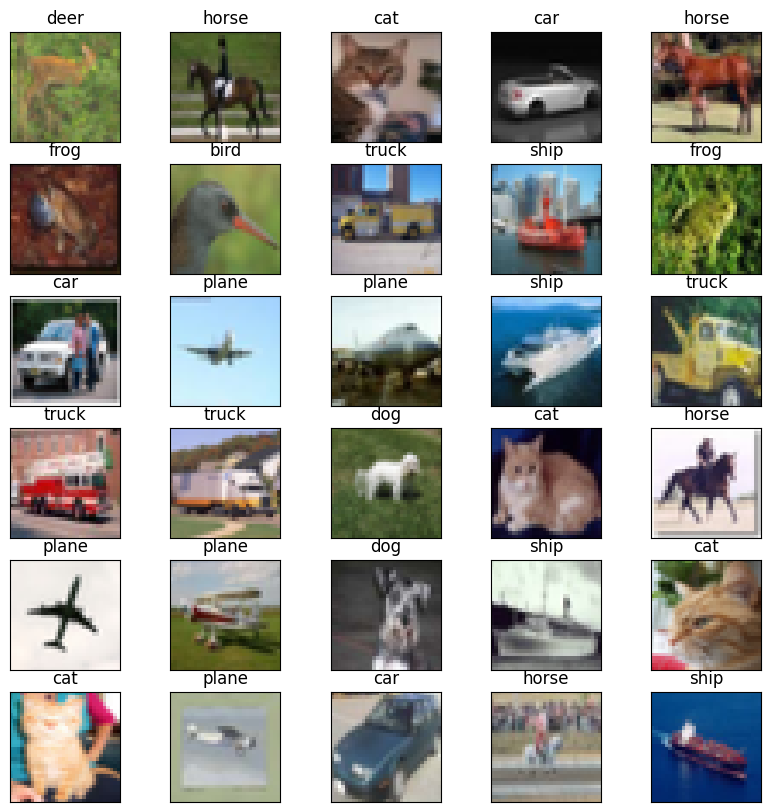

In [16]:
visualize_images()

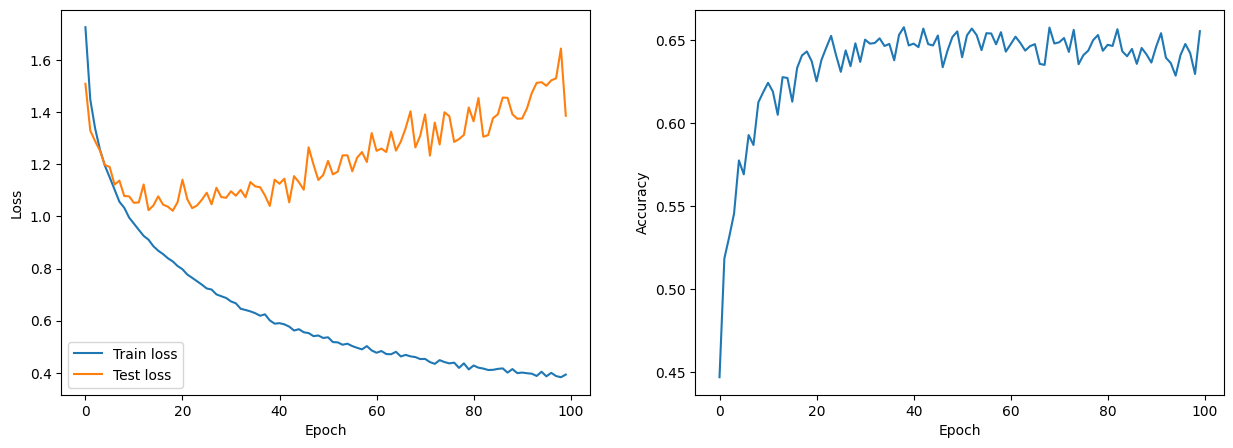

In [22]:
config, model, train_losses, test_losses, accuracies = load_experiment('experiment_1')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label='Train loss')
ax1.plot(test_losses, label='Test loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.savefig('metrics.png')
plt.show()

Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


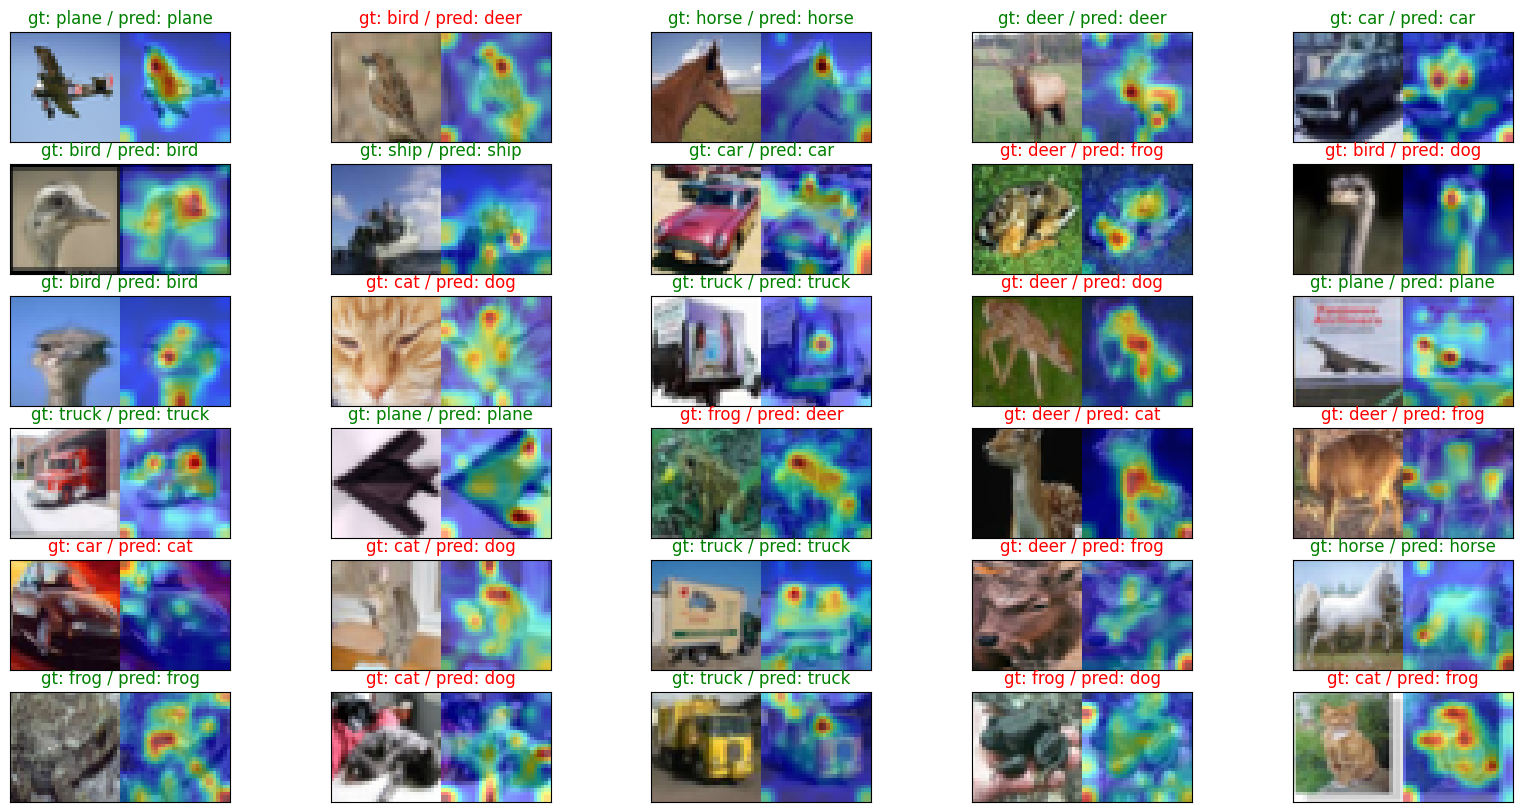

In [18]:
visualize_attention(model, 'attention.png')